In [1]:
!pip install catalax

In [1]:
import json
import jax.numpy as jnp
import catalax as ctx
import catalax.neural as ctn
from tqdm import tqdm
import numpy as np
import catalax as ctx
import catalax.mcmc as cmc

# Pretraining 

In [2]:
# Initialize the model
model = ctx.Model(name="PGM ENO")

# Add species
model.add_species("s0")
model.add_species("s1")
model.add_species("s2")

# Add ODEs
model.add_ode("s0", "- (vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))")
model.add_ode("s1", 
              """(vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))
              - (vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))
              """
             )
model.add_ode("s2", "(vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))")

# Prepare the model for bayes and define priors 
model.parameters.vf_eno.value = 1.35
model.parameters.vf_pgm.value = 9.4
model.parameters.keq_pgm.value = 0.19
model.parameters.keq_eno.value = 6.7
model.parameters.k_p2ga_pgm.value = 0.08
model.parameters.k_p3ga_pgm.value = 1.2
model.parameters.k_p2ga_eno.value = 0.04
model.parameters.k_PEP_eno.value = 0.5

model

Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[k_p2ga_pgm, vf_pgm, keq_pgm, k_p3ga_pgm, keq_eno, k_PEP_eno, k_p2ga_eno, vf_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

name      symbol  value  constant initial_value equation lower_bound  \
0   k_PEP_eno   k_PEP_eno   0.50     False          None     None        None   
1  k_p2ga_eno  k_p2ga_eno   0.04     False          None     None        None   
2  k_p2ga_pgm  k_p2ga_pgm   0.08     False          None     None        None   
3  k_p3ga_pgm  k_p3ga_pgm   1.20     False          None     None        None   
4     keq_eno     keq_eno   6.70     False          None     None        None   
5     keq_pgm     keq_pgm   0.19     False          None     None        None   
6      vf_eno      vf_eno   1.35     False          None     None        None   
7      vf_pgm      vf_pgm   9.40     False          None     None        None   

  upper_bound  
0        None  
1        None  
2        None  
3        None  
4        None  
5        None  
6        None  
7        None

In [3]:
data = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 4/Data_Testing_Set_4_20242309.npy")
time = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 4/Time_Testing_Set_4_20242309.npy")
y0s = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 4/Testing_Set_4_Initials_20242309.npy")
initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 4/Corrected_model_4_20242309.json", "r"))  
print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")
print(data.shape)
print(time.shape)
print(y0s.shape)



Time: (30, 15) | Data: (30, 15, 3) | Initial Conditions: (30, 3)
(30, 15, 3)
(30, 15)
(30, 3)


In [4]:
val_data = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/B and C/Validation_Set_B_and_C_20242309.npy")
val_time = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/B and C/Time_Validation_Set_B_and_C_20242309.npy")
val_y0s = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/B and C/Validation_Set_B_and_C_Initials_20242309.npy")
val_initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/B and C/model_Validation_Set_B_and_C_20242309.json", "r"))  

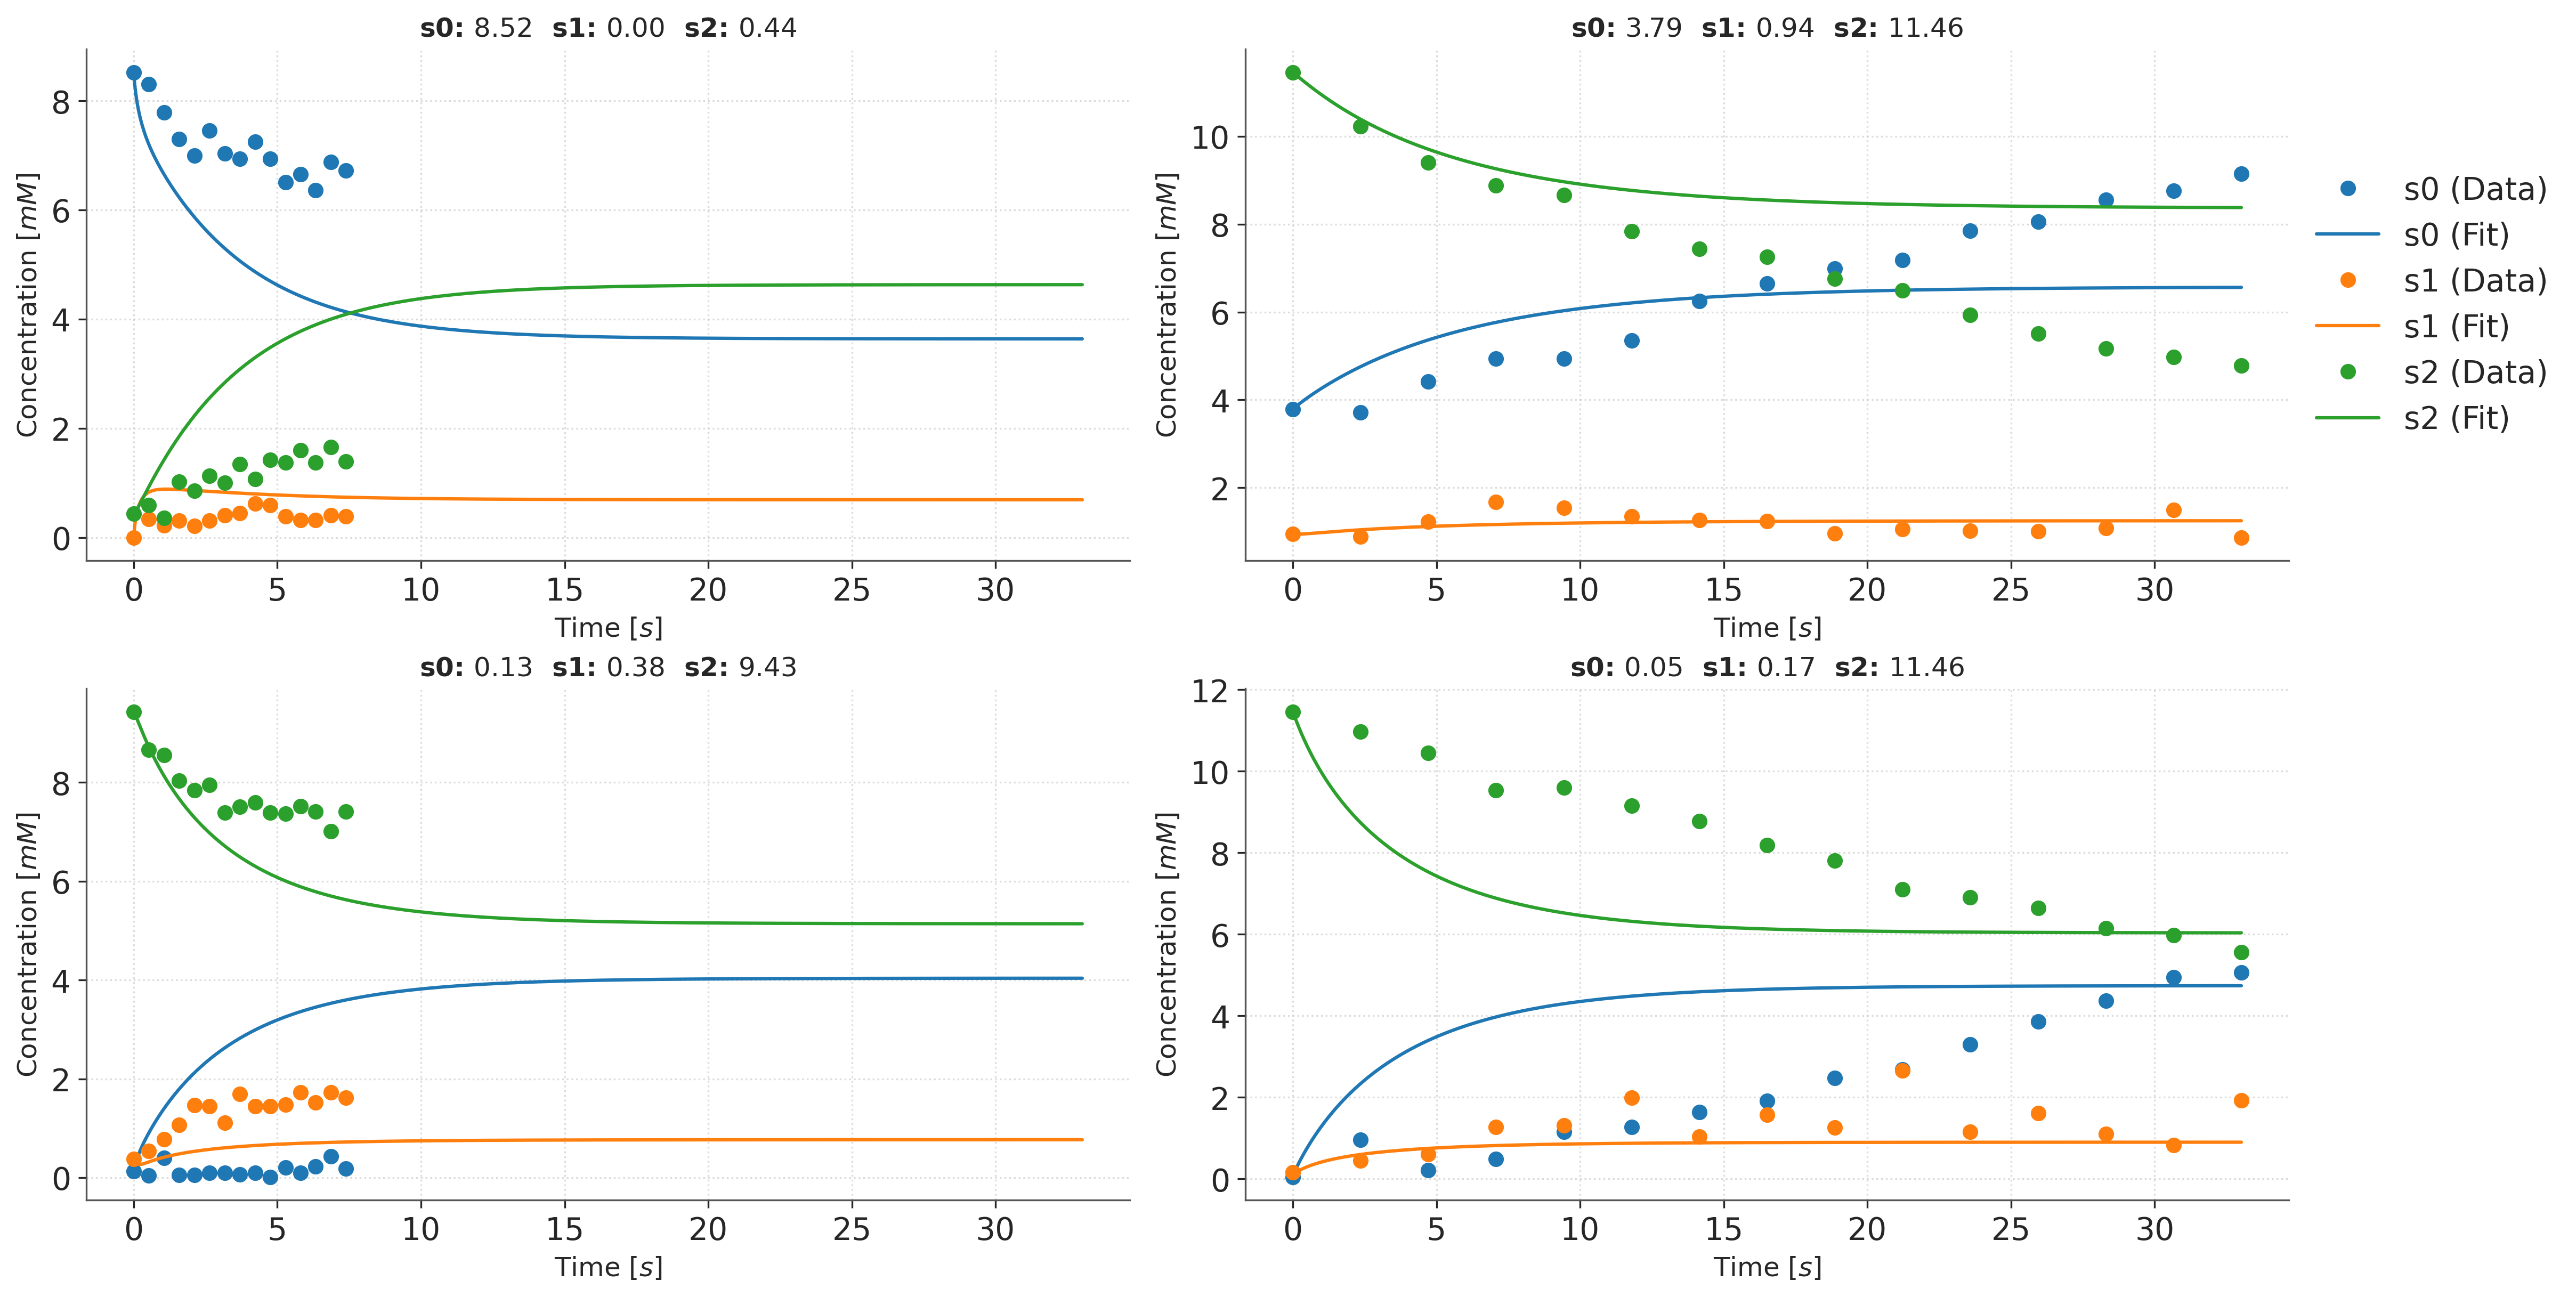

In [5]:
# Visualize the data
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(8,4),
)

In [37]:
f.savefig("C:/Users/danic/Thesis/Data/Training_Set_4_Pretrained_x_visualization.png", dpi=300, bbox_inches="tight")

# Training 

In [6]:
# Create a neural ODE model
rbf = ctn.RBFLayer(0.6)
neural_ode = ctn.NeuralODE.from_model(model, width_size=16, depth=1, activation=rbf)

# Set up a training strategy (You can interchange the loss function too!)
strategy = ctn.Strategy()
strategy.add_step(lr=1e-3, length=0.1, steps=1000, batch_size=20, alpha=0.1)
strategy.add_step(lr=1e-3, steps=3000, batch_size=20, alpha=0.01)
strategy.add_step(lr=1e-4, steps=5000, batch_size=20, alpha=0.01)

# Train neural ODE
trained = ctn.train_neural_ode(
    model=neural_ode,
    data=data,
    times=time,
    inital_conditions=y0s,
    strategy=strategy,
    sigma=0.03,
    n_augmentations=10,
    print_every=10,
    weight_scale=1e-3,
    save_milestones=False, # Set to True to save model checkpoints
    # log="progress.log", # Uncomment this line to log progress
)

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\neural\rbf.py:25: FutureWarning: uniform accepts a single key, but was given a key array of shape (1, 2) != (). Use jax.vmap for batching. In a future JAX version, this will be an error.
  self.mu = jax.random.uniform(mukey, (width_size,))



🚀 Training NeuralODE...

🔸 Step #1
├── lr: 0.001
├── batch size: 20
├── length: 10.0%
├── l2 reg: 0.1
├── train: mlp
│


╰── loss: 0.0649 mae: 0.1906: : 1010it [00:35, 28.54it/s]                                                              




🔸 Step #2
├── lr: 0.001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.2569 mae: 0.4452: : 3010it [01:01, 48.75it/s]                                                              




🔸 Step #3
├── lr: 0.0001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.2488 mae: 0.4369: : 5010it [01:14, 67.01it/s]                                                              

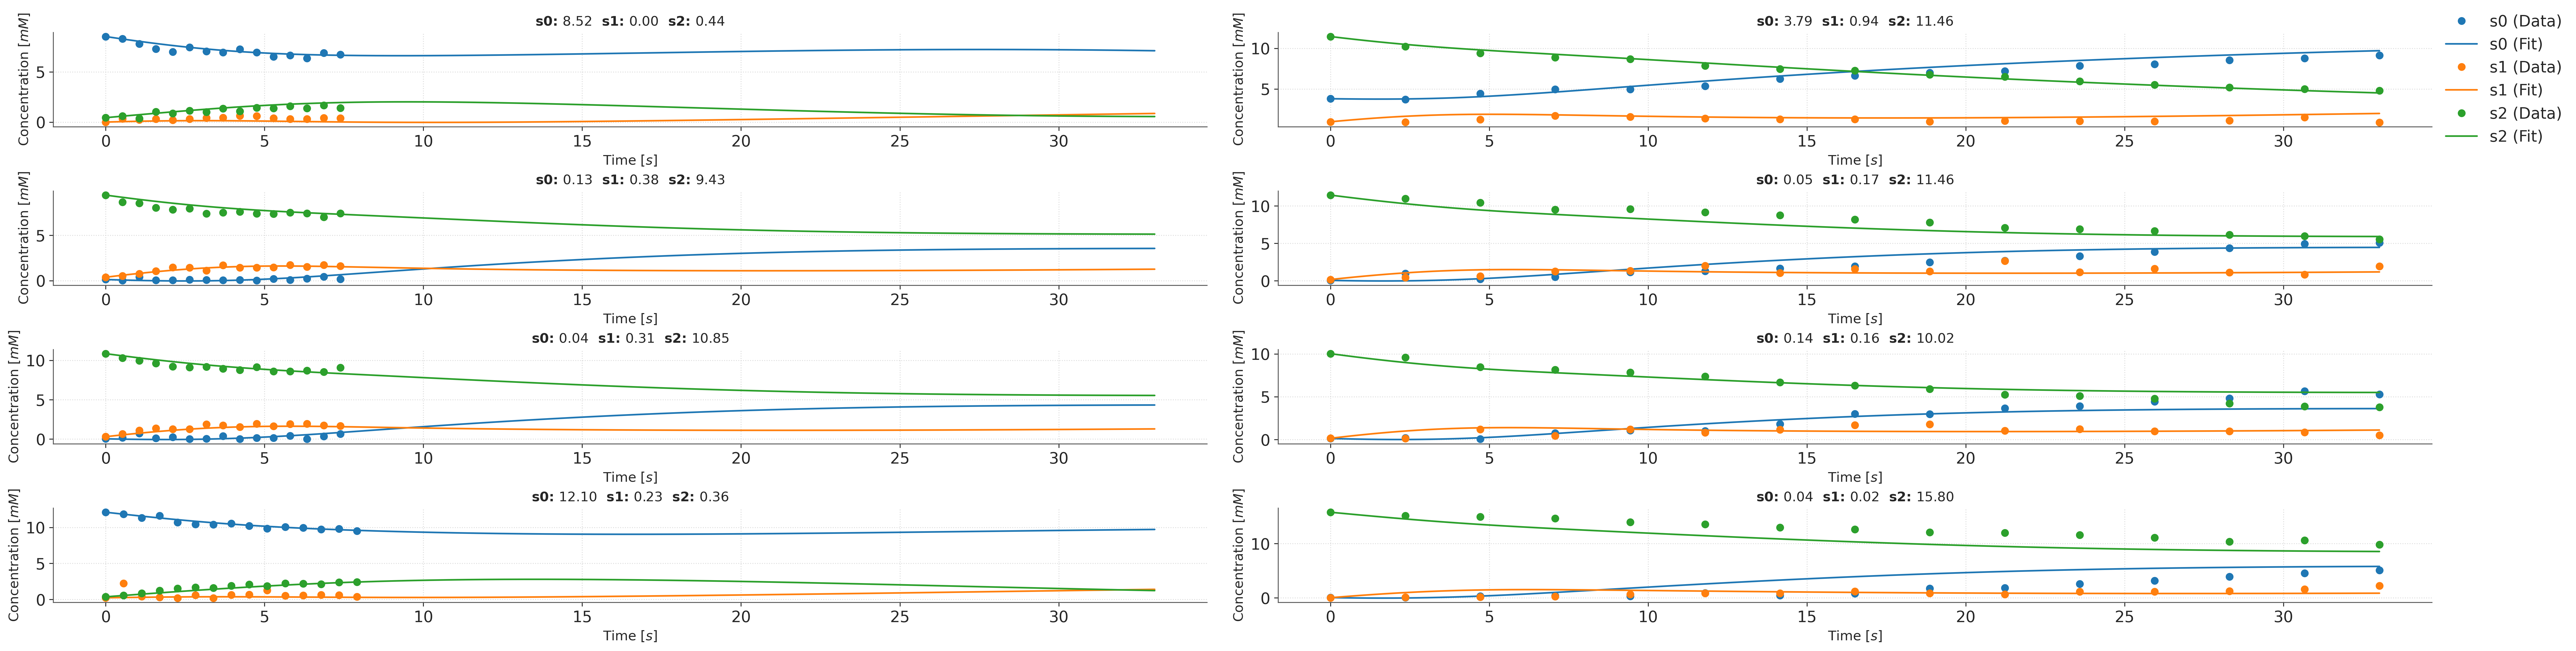

In [8]:
# Save model and visualize fit
trained.save_to_eqx("C:/Users/danic/OneDrive/Desktop/", "Training Set 4")
f = ctx.visualize(
    model=model,
    data=data[:8],
    times=time[:8],
    neural_ode=trained,
    initial_conditions=initial_conditions[:8],
    figsize=(8,4),
)

# Fit 

In [9]:
result, new_model = ctx.optimize(
    model=model,
    initial_conditions=initial_conditions,
    data=data,
    times=time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="bfgs"
)

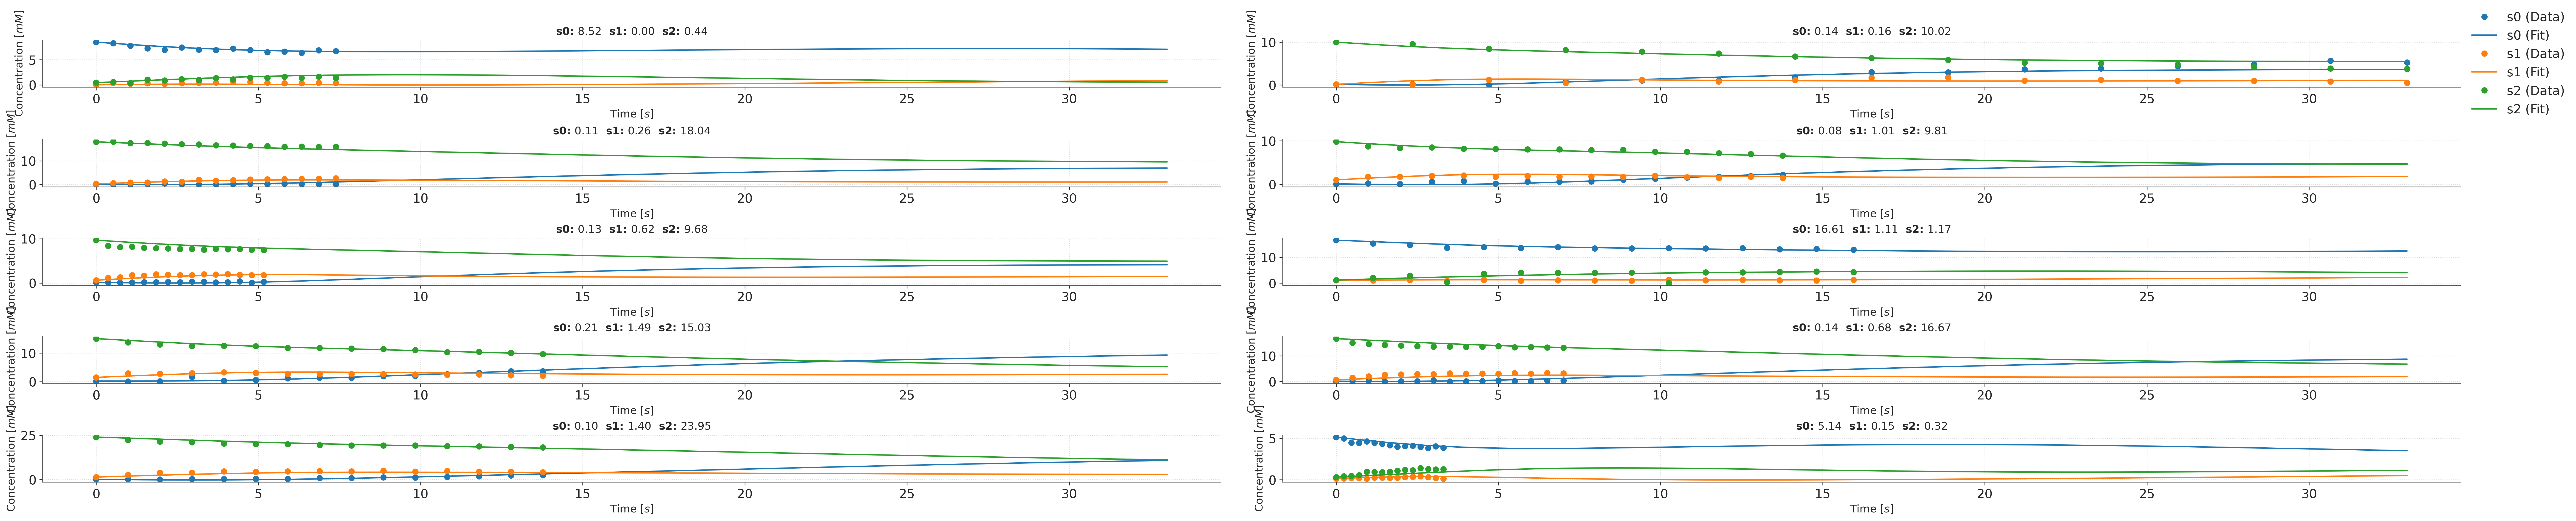

In [10]:
f = ctx.visualize(
    model=model,
    data=val_data,
    times=val_time,
    neural_ode=trained,
    initial_conditions=val_initial_conditions,
    figsize=(8,4),
)

In [51]:
result, new_model = ctx.optimize(
    model=model,
    initial_conditions=val_initial_conditions,
    data=val_data,
    times=val_time,
    global_upper_bound=1e1,
    global_lower_bound=1e-3,
    method="lmfit"
)

In [11]:
f.savefig("C:/Users/danic/Thesis/Data/Training_Set_4_VAL_visualization.png", dpi=300, bbox_inches="tight")

In [12]:
import pickle
# Save the file to a specific directory
with open("C:/Users/danic/Thesis/Data/Training_Set_VAL_visualization.pkl", "wb") as file:
    pickle.dump(f, file)


# HMC + NDE

In [13]:
# Assuming `trained_model` is your trained Neural ODE model
model


Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[k_p2ga_pgm, vf_pgm, keq_pgm, k_p3ga_pgm, keq_eno, k_PEP_eno, k_p2ga_eno, vf_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

name      symbol  value  constant  initial_value equation  \
0   k_PEP_eno   k_PEP_eno   0.50     False           0.50     None   
1  k_p2ga_eno  k_p2ga_eno   0.04     False           0.04     None   
2  k_p2ga_pgm  k_p2ga_pgm   0.08     False           0.08     None   
3  k_p3ga_pgm  k_p3ga_pgm   1.20     False           1.20     None   
4     keq_eno     keq_eno   6.70     False           6.70     None   
5     keq_pgm     keq_pgm   0.19     False           0.19     None   
6      vf_eno      vf_eno   1.35     False           1.35     None   
7      vf_pgm      vf_pgm   9.40     False           9.40     None   

   lower_bound  upper_bound  
0     0.000001     100000.0  
1     0.000001     100000.0  
2     0.000001     100000.0  
3     0.000001     100000.0  
4     0.000001     100000.0  
5     0.000001     100000.0  
6     0.000001     100000.0  
7     0.000001     100000.0

In [14]:
# Prepare the model for bayes and define priors based on the parameters produced by the Neural ODE 
model.parameters.vf_eno.value = 2.70726800
model.parameters.vf_pgm.value = 11.2055122		
model.parameters.keq_pgm.value = 0.11448425		
model.parameters.keq_eno.value = 3.32766297
model.parameters.k_p2ga_pgm.value = 0.18470698		
model.parameters.k_p3ga_pgm.value = 2.13728574			
model.parameters.k_p2ga_eno.value = 1.14325286	
model.parameters.k_PEP_eno.value = 0.40101926


In [15]:
# Define Priors

model.parameters.vf_eno.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.vf_pgm.prior= cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.keq_pgm.prior= cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p2ga_pgm.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p3ga_pgm.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p2ga_eno.prior =cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_PEP_eno.prior=cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.keq_eno.prior=cmc.priors.Uniform(low=1e-3, high=1e1)


In [16]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=2000,
    num_samples=2000,
    dt0=0.1,
    max_steps=64**4
)

🔸 Priors
├── k_p2ga_pgm: U(low=0.001, high=10.0)
├── vf_pgm: U(low=0.001, high=10.0)
├── keq_pgm: U(low=0.001, high=10.0)
├── k_p3ga_pgm: U(low=0.001, high=10.0)
├── keq_eno: U(low=0.001, high=10.0)
├── k_PEP_eno: U(low=0.001, high=10.0)
├── k_p2ga_eno: U(low=0.001, high=10.0)
├── vf_eno: U(low=0.001, high=10.0)

🚀 Running MCMC



sample: 100%|███████████████████████████| 4000/4000 [52:55<00:00,  1.26it/s, 63 steps of size 6.78e-02. acc. prob=0.87]




🎉 Finished

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   k_PEP_eno      4.20      1.81      3.93      1.30      7.12    606.34      1.00
  k_p2ga_eno      5.58      1.99      5.53      2.61      9.11    965.38      1.00
  k_p2ga_pgm      0.06      0.03      0.05      0.01      0.10    563.15      1.00
  k_p3ga_pgm      8.23      1.59      8.70      5.81     10.00    261.42      1.00
     keq_eno      4.15      0.20      4.15      3.84      4.48   1605.39      1.00
     keq_pgm      0.13      0.01      0.13      0.11      0.14   1203.33      1.00
       sigma      0.93      0.02      0.93      0.90      0.96   1668.15      1.00
      vf_eno      7.85      1.64      8.19      5.39      9.99   1065.12      1.00
      vf_pgm      5.86      2.22      5.70      2.82      9.74    374.04      1.00

Number of divergences: 26


In [19]:
##### Add parameters to the model
for param, samples in mcmc.get_samples().items():
    if param not in model.parameters:
        continue
    
    model.parameters[param].value = float(samples.mean())
    
model.parameters

name      symbol     value  constant  initial_value equation  \
0   k_PEP_eno   k_PEP_eno  4.198284     False           0.50     None   
1  k_p2ga_eno  k_p2ga_eno  5.577420     False           0.04     None   
2  k_p2ga_pgm  k_p2ga_pgm  0.055882     False           0.08     None   
3  k_p3ga_pgm  k_p3ga_pgm  8.233366     False           1.20     None   
4     keq_eno     keq_eno  4.151402     False           6.70     None   
5     keq_pgm     keq_pgm  0.128378     False           0.19     None   
6      vf_eno      vf_eno  7.845419     False           1.35     None   
7      vf_pgm      vf_pgm  5.863467     False           9.40     None   

   lower_bound  upper_bound  
0     0.000001     100000.0  
1     0.000001     100000.0  
2     0.000001     100000.0  
3     0.000001     100000.0  
4     0.000001     100000.0  
5     0.000001     100000.0  
6     0.000001     100000.0  
7     0.000001     100000.0

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\corner\core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\mcmc\plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


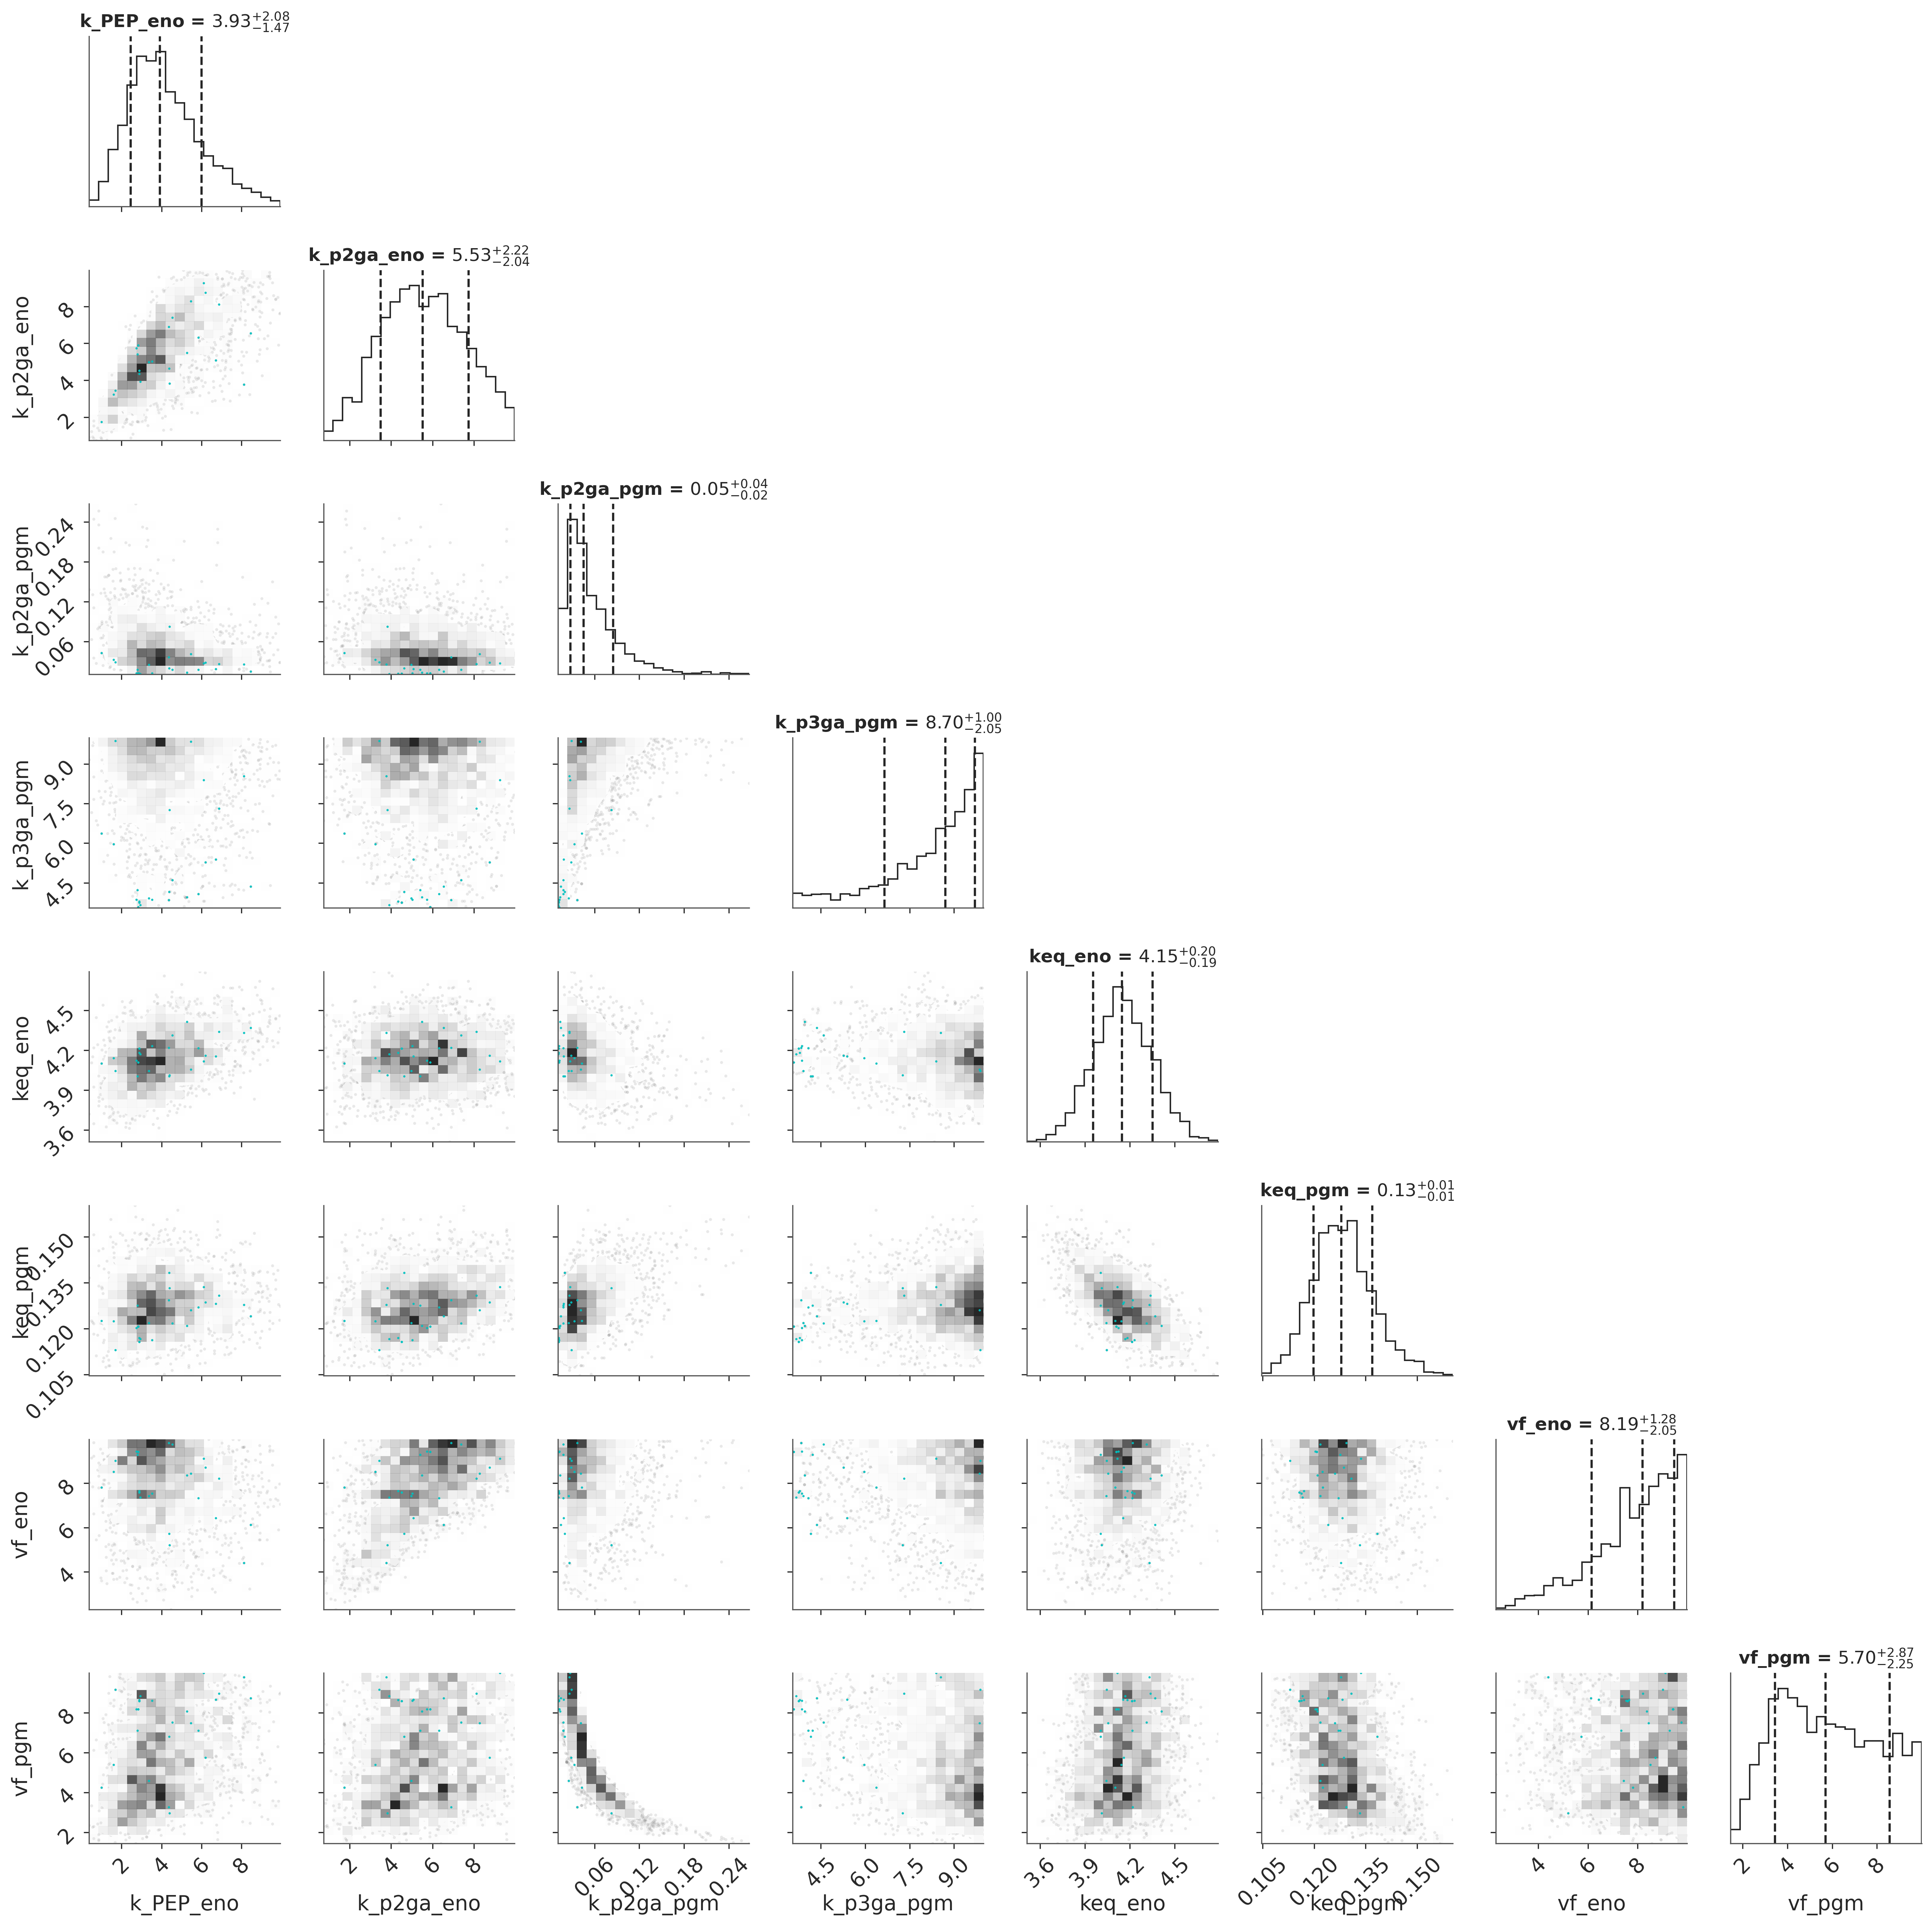

In [20]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc)

In [21]:
fig.savefig("C:/Users/danic/Thesis/Data/Corner_Plot_Set4_MCMC.png", dpi=300, bbox_inches="tight")

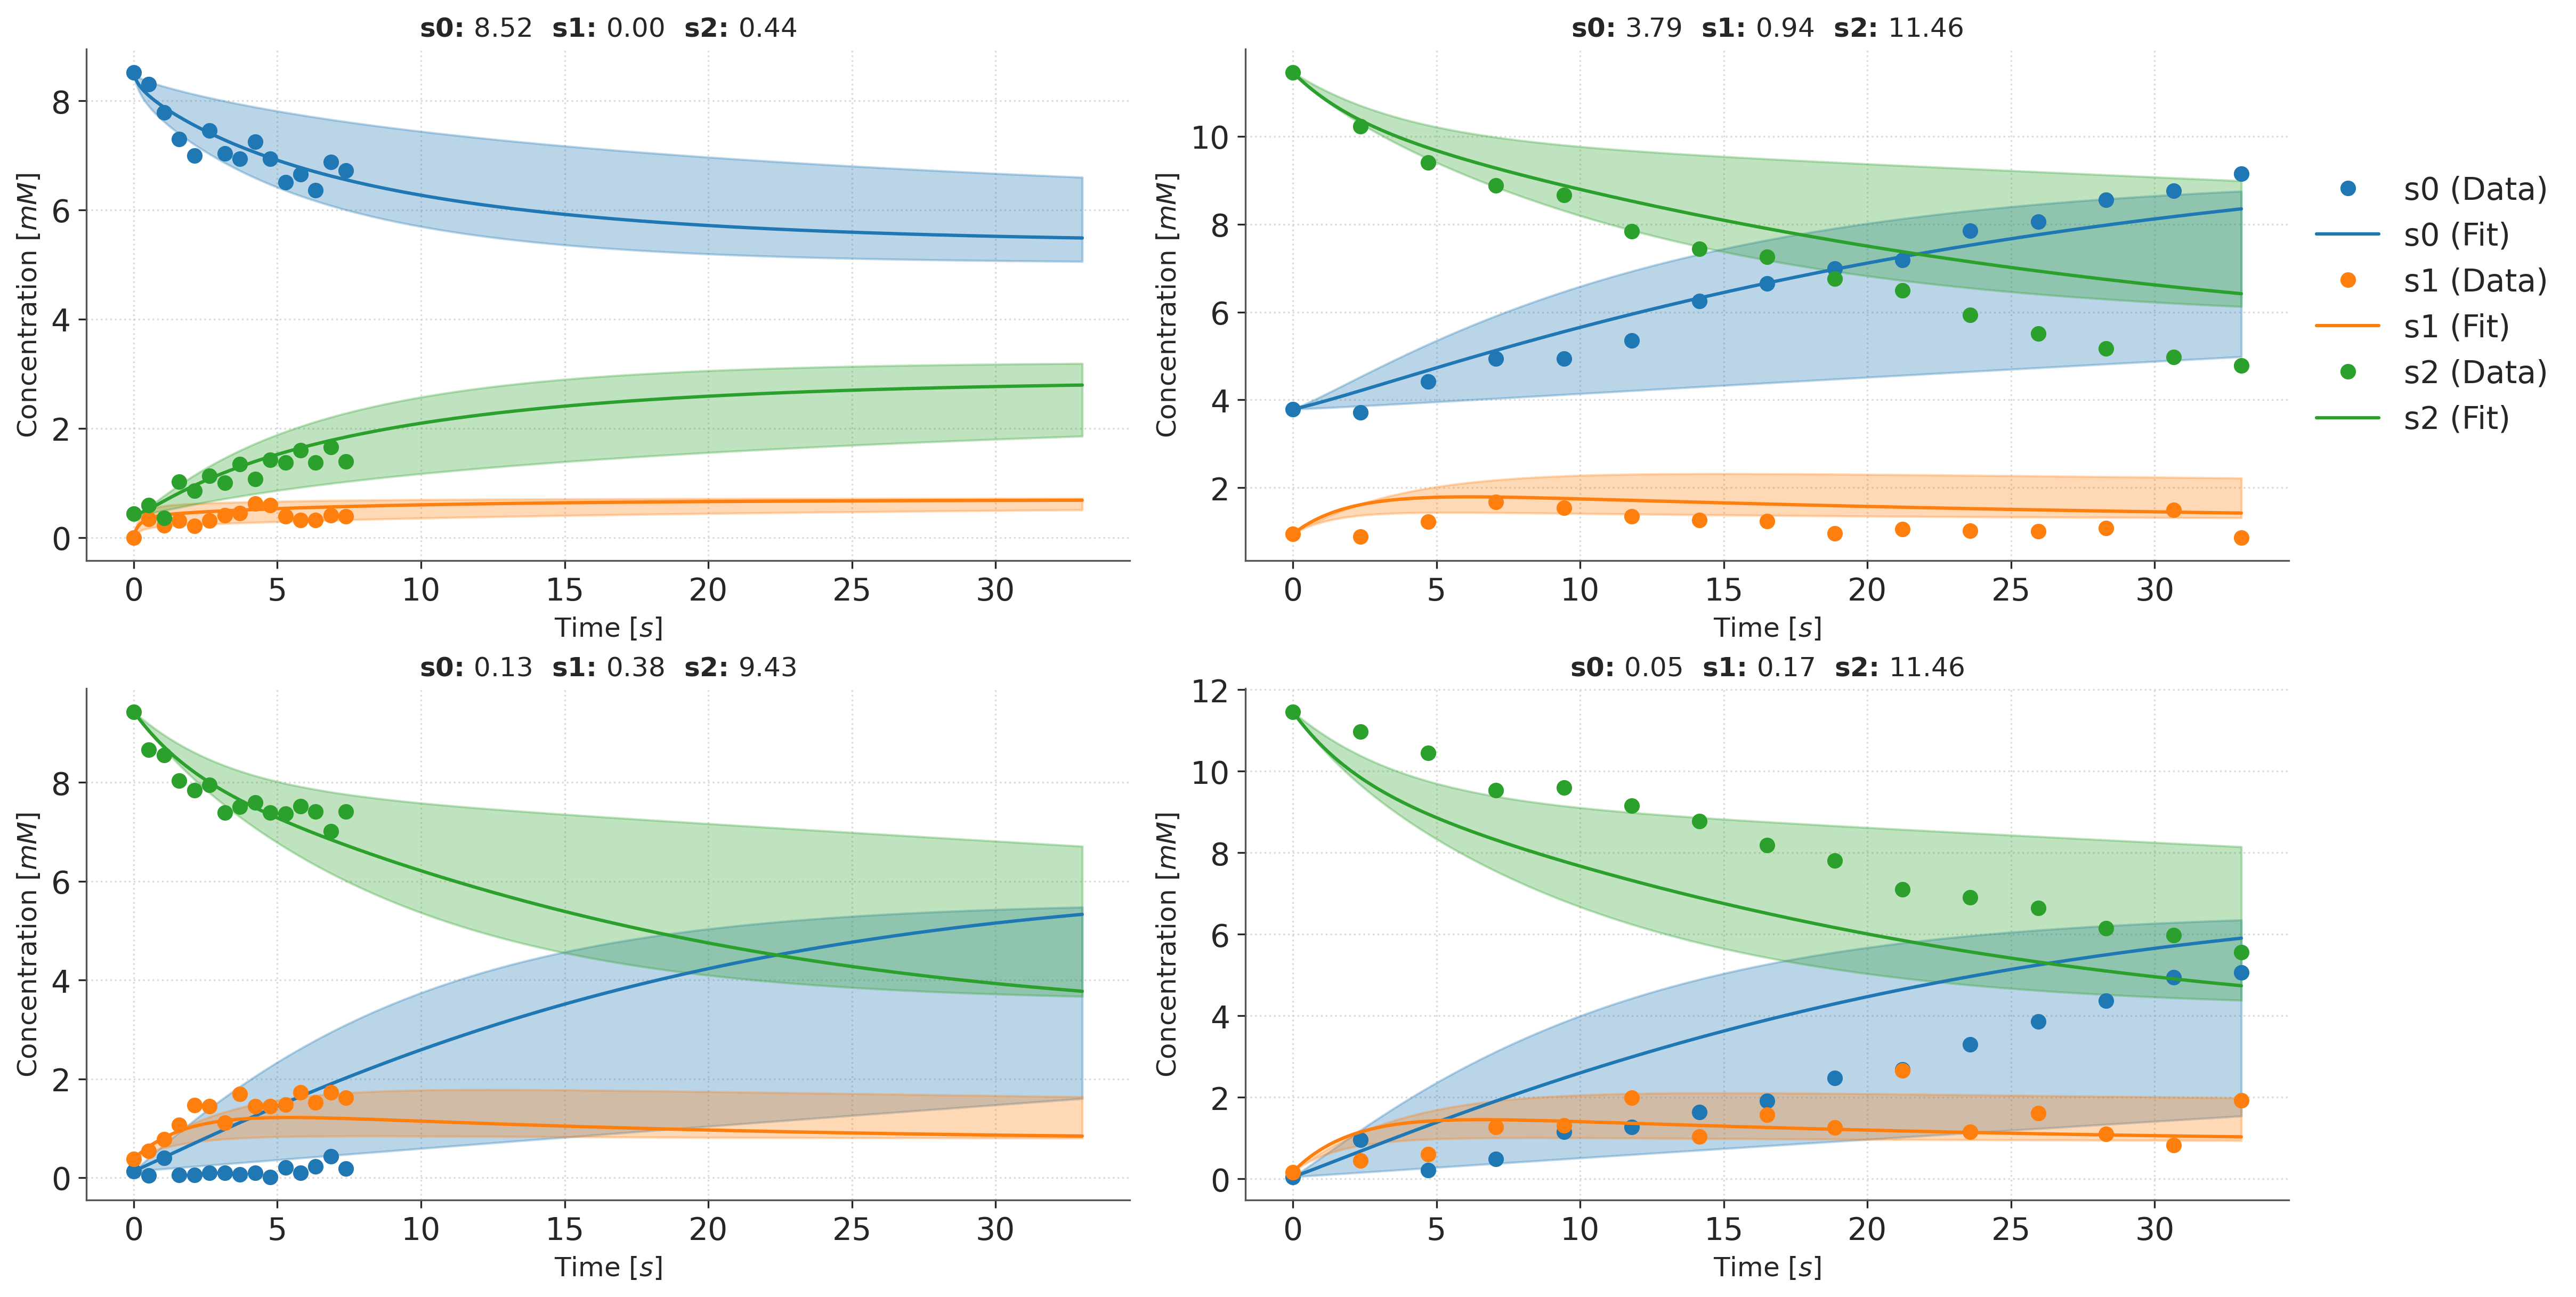

In [49]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(8,4),
    mcmc=mcmc
)

C:\Users\danic\AppData\Local\Temp\ipykernel_32636\2663279666.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


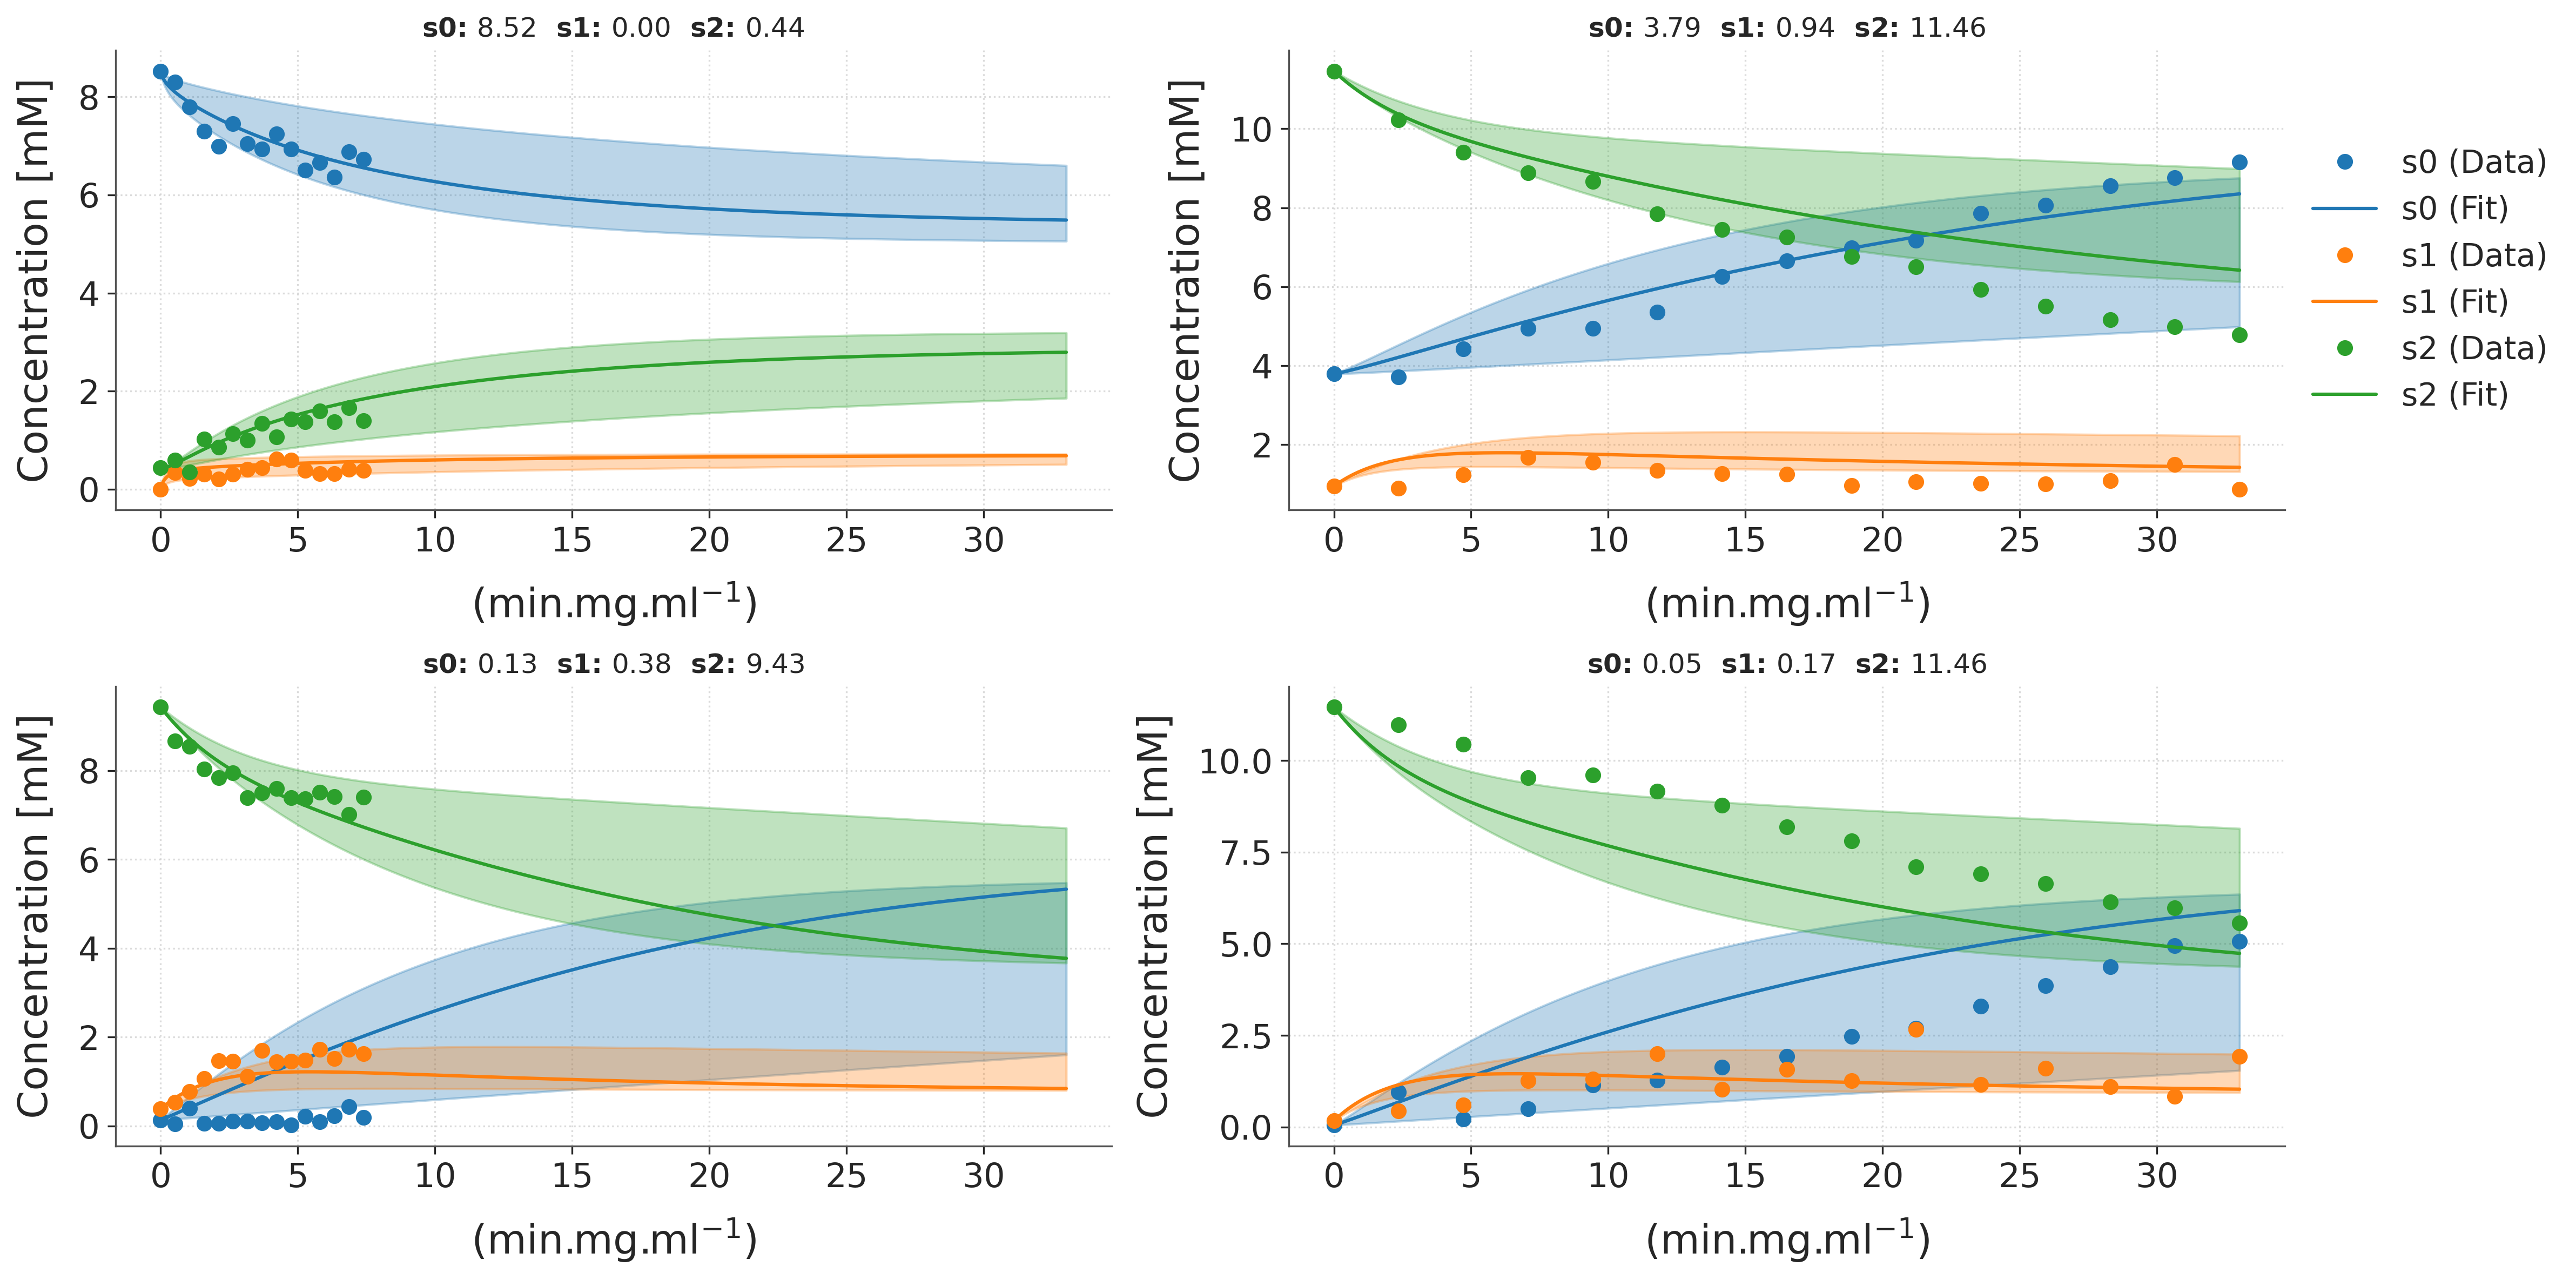

In [51]:
# Generate the figure using ctx.visualize
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(8, 4),
    mcmc=mcmc
)

# Importing matplotlib for adjustments
import matplotlib.pyplot as plt

# Loop through all axes in the figure
for ax in f.axes:
    # Set custom axis titles
    ax.set_xlabel("(min.mg.ml$^{-1}$)", fontsize=18, labelpad=10)
    ax.set_ylabel("Concentration [mM]", fontsize=18, labelpad=10)
    
    # Adjust tick label sizes
    ax.tick_params(axis='x', labelsize=15)  # x-axis tick labels
    ax.tick_params(axis='y', labelsize=15)  # y-axis tick labels

# Add tight layout for spacing adjustments
plt.tight_layout()

# Save the figure to a file
plt.savefig("Updated_Figure_With_Axis_Titles.png", dpi=300, bbox_inches="tight")

# Display the figure
plt.show()


In [52]:
f.savefig("C:/Users/danic/Thesis/Data/Training_Set_4_MCMC_visualization.png", dpi=300, bbox_inches="tight")

In [26]:
import pickle
# Save the file to a specific directory
with open("C:/Users/danic/Thesis/Data/Training_Set_4_MCMC_visualization.pkl", "wb") as file:
    pickle.dump(f, file)
